Reference: 
**S. M. Konishi, A.L. Yuille, J.M. Coughlan and S.C. Zhu. Statistical Edge Detection: Learning and Evaluating Edge Cues. IEEE Transactions on Pattern Analysis and Machine Intelligence. TPAMI. Vol. 25, No. 1, pp 57-74. January 2003.**

# Initialization and define some utility functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def myimshow(im):
    plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.gray())

# Read image and edge map

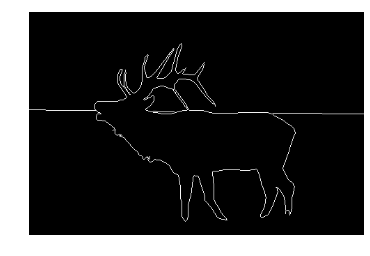

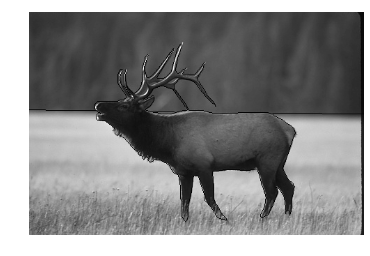

In [2]:
# Show image and edge labeling
# id = '100075'
# id = '35010' # butterfly
# id = '97017' # building
id = '41004' # deer
# Change the id to try a differnt image

def loadData(id):
    from skimage.color import rgb2gray
    edgeMap = plt.imread('../data/edge/boundaryMap/' + id + '.bmp'); edgeMap = edgeMap[:,:,0]
    im = plt.imread('../data/edge/trainImgs/' + id + '.jpg')
    grayIm = rgb2gray(im)
    return [grayIm, edgeMap]

[im, edgeMap] = loadData(id)
myimshow(edgeMap); # title('Boundary')
myimshow(im * (edgeMap==0)); # title('Image with boundary')

# Define function to filter image 
$ \frac{dI}{dx} $, $ \frac{dG*I}{dx} $

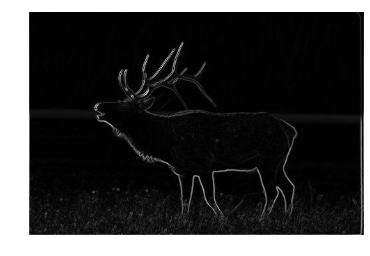

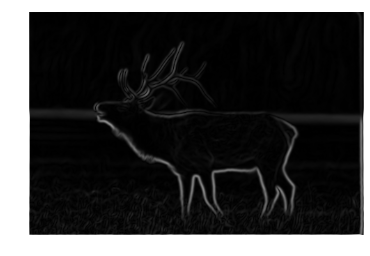

In [3]:
def dIdx(im):
    # Compute magnitude of gradient
    # 'CentralDifference' : Central difference gradient dI/dx = (I(x+1)- I(x-1))/ 2
    dx = (np.roll(im, 1, axis=1) - np.roll(im, -1, axis=1))/2
    dy = (np.roll(im, 1, axis=0) - np.roll(im, -1, axis=0))/2
    mag = np.sqrt(dx**2 + dy**2)
    return mag

def dgIdx(im, sigma=1.5):
    from scipy.ndimage import gaussian_filter
    gauss = gaussian_filter(im, sigma = sigma)
    dgauss = dIdx(gauss)
    return dgauss

dx = dIdx(im)
dgI = dgIdx(im)

# Show filtered images
myimshow(dx); # title(r'$ \frac{dI}{dx} $')
myimshow(dgI); # title(r'$ \frac{d G*I}{dx} $')

# def showEdge(im, edgeMap):
#     # draw edge pixel
#     im = im * (edgeMap != 0)
#     figure(); myimshow(im); title('Highlight edge')

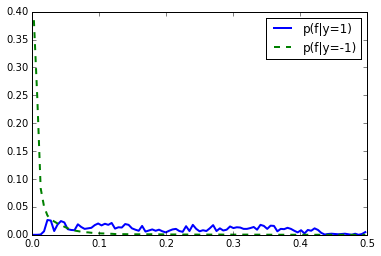

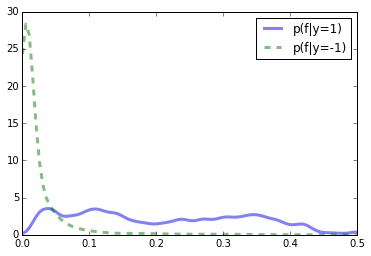

In [34]:
def kde(x):
    # Kernel density estimation, to get P(dI/dx | on edge) and P(dI/dx | off edge) from data
    from scipy.stats import gaussian_kde
    f = gaussian_kde(x, bw_method=0.01 / x.std(ddof=1))
    return f
    
def ponEdge(im, edgeMap):
    # Compute on edge histogram
    # im is filtered image
    
    # Convert edge map to pixel index
    flattenEdgeMap = edgeMap.flatten()
    edgeIdx = [i for i in range(len(flattenEdgeMap)) if flattenEdgeMap[i]]
    
    # find edge pixel in 3x3 region, shift the edge map a bit, in case of inaccurate boundary labeling
    [offx, offy] = np.meshgrid(np.arange(-1,2), np.arange(-1,2)); offx = offx.flatten(); offy = offy.flatten()
    maxVal = np.copy(im)
    for i in range(9):
        im1 = np.roll(im, offx[i], axis=1) # x axis
        im1 = np.roll(im1, offy[i], axis=0) # y axis    
        maxVal = np.maximum(maxVal, im1)

    vals = maxVal.flatten()
    onEdgeVals = vals[edgeIdx]
    
    bins = np.linspace(0,0.5, 100)
    [n, bins] = np.histogram(onEdgeVals, bins=bins)
    # n = n+1 # Avoid divide by zero

    pon = kde(onEdgeVals)

    return [n, bins, pon]


def poffEdge(im, edgeMap):
    flattenEdgeMap = edgeMap.flatten()
    noneEdgeIdx = [i for i in range(len(flattenEdgeMap)) if not flattenEdgeMap[i]]
    
    vals = im.flatten()
    offEdgeVals = vals[noneEdgeIdx] 

    bins = np.linspace(0,0.5, 100)
    n, bins = np.histogram(offEdgeVals, bins=bins)

    # n = n+1
    # p = n / sum(n)
    
    poff = kde(offEdgeVals)
    
    return [n, bins, poff]

dx = dIdx(im)
[n1, bins, pon] = ponEdge(dx, edgeMap)
[n2, bins, poff] = poffEdge(dx, edgeMap)

plt.figure(); # Plot on edge
# title('(Normalized) Histogram of on/off edge pixels')
plt.plot((bins[:-1] + bins[1:])/2, n1.astype(float)/sum(n1), '-', lw=2, label="p(f|y=1)")
plt.plot((bins[:-1] + bins[1:])/2, n2.astype(float)/sum(n2), '--', lw=2, label="p(f|y=-1)")
plt.legend()

plt.figure()
# title('Density function of on/off edge pixels')
plt.plot(bins, pon(bins), '-', alpha=0.5, lw=3, label="p(f|y=1)")
plt.plot(bins, poff(bins), '--', alpha=0.5, lw=3, label="p(f|y=-1)")
plt.legend()

# Compute $ P(\frac{dI}{dx} | \text{on edge}) $ and $ P(\frac{dI}{dx} | \text{off edge}) $

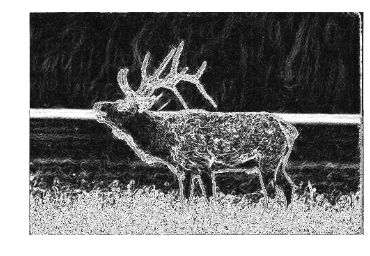

In [5]:
ponIm = pon(dx.flatten()).reshape(dx.shape) # evaluate pon on a vector and reshape the vector to the image size
myimshow(ponIm)

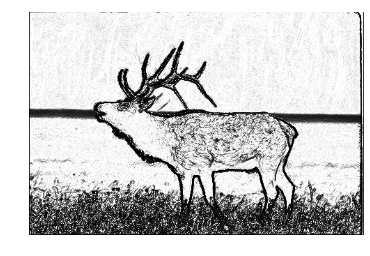

In [6]:
poffIm = poff(dx.flatten()).reshape(dx.shape) # Slow, evaluation of this cell may take several minutes
myimshow(poffIm)

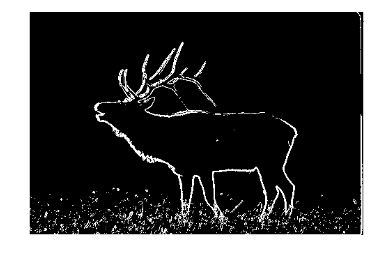

In [7]:
T = 1
myimshow(log(ponIm/poffIm)>T) # 

# Show ROC curve

In [8]:
gt = (edgeMap!=0)
print np.sum(gt == True) # Edge
print np.sum(gt == False) # Non-edge

2086
152315


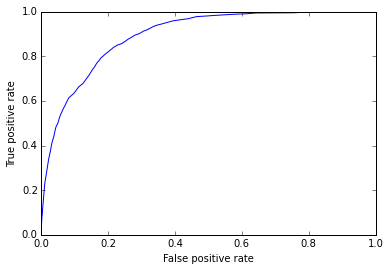

In [9]:
def ROCpoint(predict, gt):
    # predict = (log(ponIm/poffIm)>=T)
    truePos = (predict==True) & (gt == predict)
    trueNeg = (predict==False) & (gt == predict)

    falsePos = (predict==True) & (gt != predict)
    falseNeg = (predict==False) & (gt != predict)

    y = double(truePos.sum()) / np.sum(gt == True)
    x = double(falsePos.sum()) / np.sum(gt == False)
    return [x, y]

p = []
for T in np.arange(-5, 5, step=0.1):
    predict = (log(ponIm/poffIm)>=T)
    p.append(ROCpoint(predict, gt))
x = [v[0] for v in p]
y = [v[1] for v in p]
plt.plot(x, y)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

## Interactive: Change threshold 

Below is an interactive demo to show the result for different threshold T. You can also observe the point on ROC curve.

(Evaluate next cell to run the demo)

<img width="600" src='../data/edge/snapshot.png'>

<function __main__.demoThreshold>

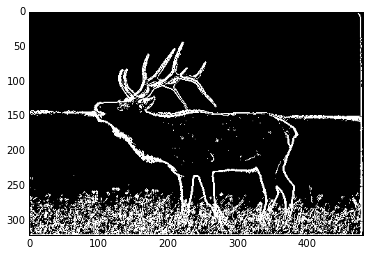

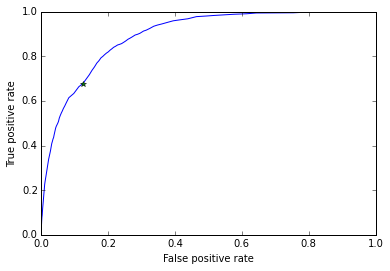

In [10]:
# interactive threshold demo, evaluate this cell
from IPython.html.widgets import interact, interactive, fixed
def demoThreshold(T):
    predict = (log(ponIm/poffIm)>=T)
    plt.figure(1)
    imshow(predict)
    p = ROCpoint(predict, gt)
    plt.figure(2)
    plt.plot(x, y)
    plt.plot(p[0], p[1], '*')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

# compute ROC curve
p = []
for T in np.arange(-5, 5, step=0.1):
    predict = (log(ponIm/poffIm)>=T)
    p.append(ROCpoint(predict, gt))
x = [v[0] for v in p]
y = [v[1] for v in p]
    
interact(demoThreshold, T=(-5, 5, 0.1))

# Homework 1.4:
1. Load another image, apply this edge detection algorithm, find a good threshold and display your result
2. Use $ \frac{dG*I}{dx} $ for edge detection. G is a Gaussian. Show results for different variances.

# Answer of HW1.4

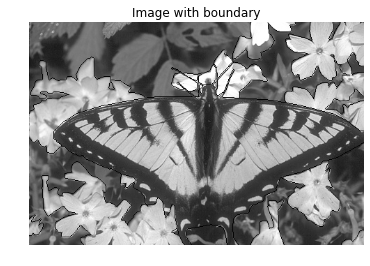

In [11]:
# Part1 of HW1.4
# load another image
id = '35010' # butterfly
def loadData(id):
    from skimage.color import rgb2gray
    edgeMap = imread('../data/edge/boundaryMap/' + id + '.bmp'); edgeMap = edgeMap[:,:,0]
    im = imread('../data/edge/trainImgs/' + id + '.jpg')
    grayIm = rgb2gray(im)
    return [grayIm, edgeMap]

[im, edgeMap] = loadData(id)
gt = (edgeMap!=0)
figure(); myimshow(im * (edgeMap==0)); title('Image with boundary')

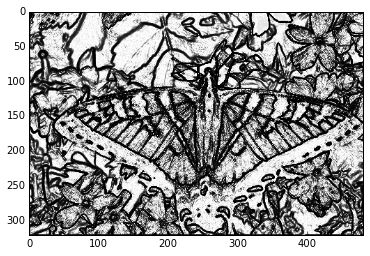

In [12]:
# Apply edge detection algorithm
dx = dIdx(im)
ponIm = pon(dx.flatten()).reshape(dx.shape) # evaluate pon on a vector and reshape the vector to the image size
figure; imshow(ponIm)
poffIm = poff(dx.flatten()).reshape(dx.shape) # Slow, evaluation of this cell may take several minutes
figure; imshow(poffIm)

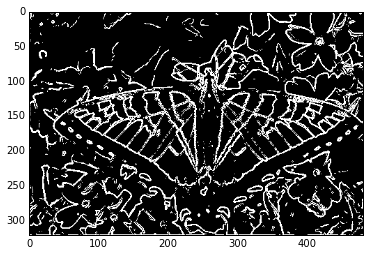

In [13]:
T = 1
imshow(log(ponIm/poffIm)>T) # 

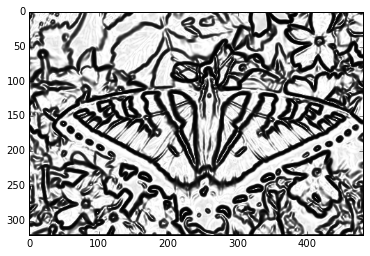

In [14]:
# Part2 of HW1.4
# Apply Gaussian filter to image, with a small sigma
dx = dgIdx(im, sigma=1.5) 
ponIm = pon(dx.flatten()).reshape(dx.shape) # evaluate pon on a vector and reshape the vector to the image size
figure; imshow(ponIm)
poffIm = poff(dx.flatten()).reshape(dx.shape) # Slow, evaluation of this cell may take several minutes
figure; imshow(poffIm)

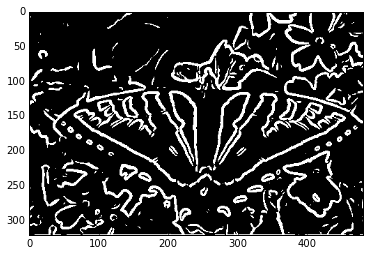

In [15]:
T = 0.2
imshow(log(ponIm/poffIm)>T)  

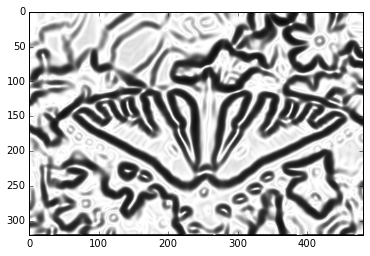

In [16]:
# Apply Gaussian filter to image, with a bigger sigma
dx = dgIdx(im, sigma=4)
ponIm = pon(dx.flatten()).reshape(dx.shape) # evaluate pon on a vector and reshape the vector to the image size
figure; imshow(ponIm)
poffIm = poff(dx.flatten()).reshape(dx.shape) # Slow, evaluation of this cell may take several minutes
figure; imshow(poffIm)

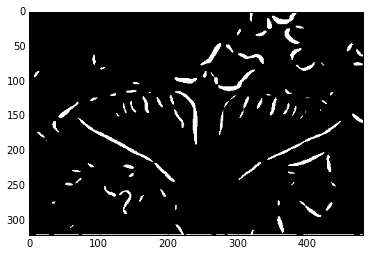

In [17]:
T = 0.001
imshow(log(ponIm/poffIm)>T)  